In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style as style
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import math

### Prepare Train Data and Test Data

In [2]:
df = pd.read_csv('ratings.csv')
df = df[['userId', 'movieId', 'rating']]
# Shuffle the total data
df = df.sample(frac=1).reset_index(drop=True)
usersList = pd.unique(df['userId'])
moviesList = pd.unique(df['movieId'])
numUsers = len(usersList)
numMovies = len(moviesList)
numRows = df.shape[0]
# The first 80% rows will go to Train Data
trainNumRows = (8 * numRows) // 10

In [3]:
train_df = df.iloc[:trainNumRows,:]
trainList = []
for index, row in train_df.iterrows():
    trainList.append((row['userId'], row['movieId'], row['rating']))
train_df = df.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)

test_df = df.iloc[trainNumRows:,:]
testList = []
for index, row in test_df.iterrows():
    testList.append((row['userId'], row['movieId'], row['rating']))
    train_df.at[row['userId'], row['movieId']] = 0
test_df = df.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
for user, movie, rating in trainList:
    test_df.at[row['userId'], row['movieId']] = 0
    
train_df.shape

(610, 9724)

### Compute Low Rank Approximation and Error

In [4]:
def computeError(pred_df, testList):
    err = 0
    for user, movie, actualRating in testList:
        predictedRating = pred_df.at[user, movie]
        current_err = (predictedRating - actualRating) ** 2
        err += current_err
    return err

In [5]:
# Single Value Decomposition
train_matrix= train_df.to_numpy()

U, D, Vt = np.linalg.svd(train_matrix)

In [6]:
#compute error for each k
errorList = []
for k in tqdm(range(100), leave = False):
    pred = np.zeros((len(U), len(Vt)))
    for i in range(k):
        pred += D[i] * np.outer(U.T[i], Vt[i])
    pred_df = pd.DataFrame(pred, index = train_df.index, columns = train_df.columns)
    errorVal = computeError(pred_df, testList)
    errorList.append(errorVal)

  0%|          | 0/100 [00:00<?, ?it/s]

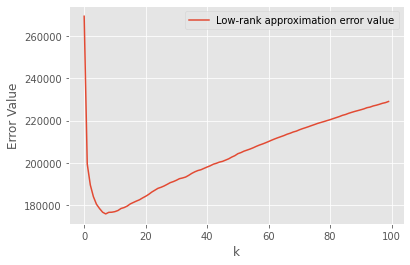

In [7]:
style.use('ggplot')
plt.plot(list(range(100)), errorList, label="Low-rank approximation error value")
plt.xlabel('k')
plt.ylabel('Error Value')
plt.legend()
plt.show()

### BaseLine Algorithm

In [8]:
train_df = train_df.replace(0, np.NaN)
userAvg = train_df.mean(axis = 1, skipna = True)
movieAvg = train_df.mean(axis = 0, skipna = True)

In [9]:
# Fit the curve for parameters alpha, beta
def rating_function(X, a, b):
    user_avg, movie_avg = X
    result = a * user_avg + b * movie_avg
    return result
def fit_variables(movieAvg, userAvg, test_df):
    userData = []
    movieData = []
    actualRating = []
    for row in trainList:
        userData.append(userAvg[row[0]])
        movieData.append(movieAvg[row[1]])
        actualRating.append(row[2])
    return curve_fit(rating_function, (userData, movieData), actualRating)

In [10]:
(alpha, beta), pArray = fit_variables(movieAvg, userAvg, test_df)
print(alpha, beta)

0.3635038528557017 0.6442918032391023


In [11]:
def computeBaseLineError(alpha, beta, testList):
    err = 0
    for user, movie, actualRating in testList:
        predictedRating = 0
        if movie in movieAvg and user in userAvg:
            predictedRating = alpha * userAvg[user] + beta * movieAvg[movie]
        if math.isnan(predictedRating):
            predictedRating = 0
        current_err = (predictedRating - actualRating) ** 2
#         print(predictedRating, actualRating)
        err += current_err
#     print(err)
    return err

In [12]:
baseLineErrorList = []
for k in tqdm(range(100), leave = False):
    errorVal = computeBaseLineError(alpha, beta, testList)
    baseLineErrorList.append(errorVal)

  0%|          | 0/100 [00:00<?, ?it/s]

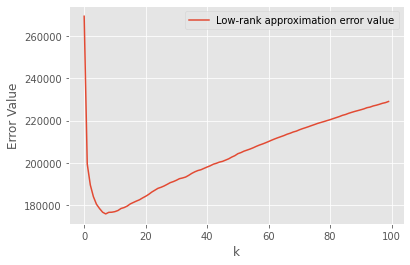

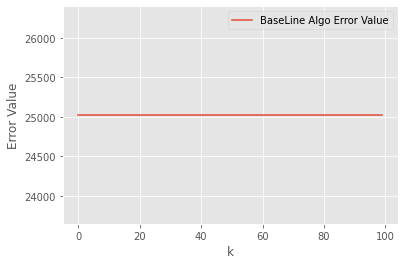

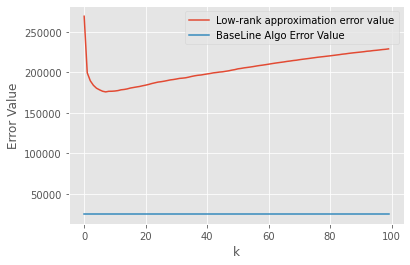

In [13]:
style.use('ggplot')
# Low Rank Approximation Error
plt.plot(list(range(100)), errorList, label="Low-rank approximation error value")
plt.xlabel('k')
plt.ylabel('Error Value')
plt.legend()
plt.show()

# BaseLine Algo Error Plot
plt.plot(list(range(100)), baseLineErrorList, label="BaseLine Algo Error Value")
plt.xlabel('k')
plt.ylabel('Error Value')
plt.legend()
plt.show()

# Comparison Plot
plt.plot(list(range(100)), errorList, label="Low-rank approximation error value")
plt.plot(list(range(100)), baseLineErrorList, label="BaseLine Algo Error Value")
plt.xlabel('k')
plt.ylabel('Error Value')
plt.legend()
plt.show()